In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torchviz

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchviz import make_dot

In [3]:
class ResNetBlock(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size, 
                 kernel_size=3, 
                 stride=1, 
                 padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_size, 
                               hidden_size, 
                               kernel_size=kernel_size, 
                               stride=stride, 
                               padding=padding)
        self.conv2 = nn.Conv2d(hidden_size, 
                               output_size,
                               kernel_size=kernel_size, 
                               stride=stride, 
                               padding=padding)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(hidden_size)
        self.bn2 = nn.BatchNorm2d(output_size)

        if input_size != output_size:
            self.match_dimesions = nn.Conv2d(input_size, 
                                             output_size, 
                                             kernel_size=1)
        else:
            self.match_dimesions = None
            
    def forward(self, input_layer):
        hidden_layer = self.conv1(input_layer)
        hidden_layer = self.bn1(hidden_layer)
        hidden_layer = self.relu(hidden_layer)
        output_layer = self.conv2(hidden_layer)
        output_layer = self.bn2(output_layer)
        
        if self.match_dimesions:
            input_layer = self.match_dimesions(input_layer)

        output_layer += input_layer
        output_layer = self.relu(output_layer)
        return output_layer

In [4]:
class ResNet(nn.Module):
    def __init__(self,
                 input_size,
                 num_classes,
                 dropout_ratio=0.5):
        super().__init__()
        self.conv = nn.Conv2d(input_size,
                              64,
                              kernel_size=7,
                              stride=2,
                              padding=3)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(64)

        self.blocks = nn.ModuleList([
            ResNetBlock(64, 64, 64),
            ResNetBlock(64, 128, 128),
            ResNetBlock(128, 256, 256),
            ResNetBlock(256, 256, 512)
        ])

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(dropout_ratio)
        self.softmax = nn.LogSoftmax(dim=1)
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

    def forward(self, x):
        hidden_layer = self.conv(x)
        hidden_layer = self.bn(hidden_layer)
        hidden_layer = self.relu(hidden_layer)

        for block in self.blocks:
            hidden_layer = block(hidden_layer)

        hidden_layer = self.pool(hidden_layer)
        hidden_layer = hidden_layer.view(hidden_layer.size(0), -1)
        hidden_layer = self.dropout(hidden_layer)
        output_layer = self.fc(hidden_layer)
        output = self.softmax(output_layer)
        return output
    
    def train_model(self, 
                    train_loader, 
                    val_loader, 
                    device,
                    lr=1e-2, 
                    num_epochs=100, 
                    print_every=10):
        self.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                   'min', 
                                                   factor=0.1, 
                                                   patience=5)
        self.loss_history = []

        for epoch in range(num_epochs):
            epoch_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self.forward(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            epoch_loss /= len(train_loader)
            train_acc = 100 * correct / total
            self.loss_history.append(epoch_loss)
            self.train_acc_history.append(train_acc)

            val_acc = self.evaluate(val_loader, device)
            self.val_acc_history.append(val_acc)

            scheduler.step(epoch_loss)

            if (epoch + 1) % print_every == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.8f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    def evaluate(self, val_loader, device):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.forward(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        self.train()  # Switch back to training mode
        return 100 * correct / total

    def visualize_metrics(self):
        plt.figure(figsize=(6, 5))
        
        # Plot loss history
        plt.plot(self.loss_history, label='Loss')
        plt.title('Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Plot accuracy history
        plt.figure(figsize=(6, 5))
        plt.plot(self.train_acc_history, label='Train Accuracy')
        plt.plot(self.val_acc_history, label='Val Accuracy')
        plt.title('Accuracy History')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [5]:
def loader(batch_size=128):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=transform)
    val_dataset = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
model = ResNet(input_size=3, num_classes=10)
model.to(device)

ResNet(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (relu): ReLU()
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): ModuleList(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [8]:
train_loader, val_loader = loader()
model.train_model(train_loader, val_loader,
                  device=device,  # Pass the device to the training function
                  lr=1e-2,
                  num_epochs=100,
                  print_every=10)

Files already downloaded and verified
Files already downloaded and verified
Epoch [10/100], Loss: 0.70587850, Train Acc: 75.63%, Val Acc: 69.70%
Epoch [20/100], Loss: 0.46786425, Train Acc: 83.91%, Val Acc: 79.90%
Epoch [30/100], Loss: 0.35307530, Train Acc: 87.85%, Val Acc: 83.41%
Epoch [40/100], Loss: 0.28346975, Train Acc: 90.22%, Val Acc: 84.04%
Epoch [50/100], Loss: 0.23356927, Train Acc: 91.89%, Val Acc: 84.31%
Epoch [60/100], Loss: 0.20657121, Train Acc: 92.85%, Val Acc: 84.45%
Epoch [70/100], Loss: 0.17613114, Train Acc: 93.78%, Val Acc: 84.98%
Epoch [80/100], Loss: 0.15254637, Train Acc: 94.78%, Val Acc: 84.43%
Epoch [90/100], Loss: 0.13809343, Train Acc: 95.31%, Val Acc: 85.23%
Epoch [100/100], Loss: 0.12849280, Train Acc: 95.56%, Val Acc: 85.21%


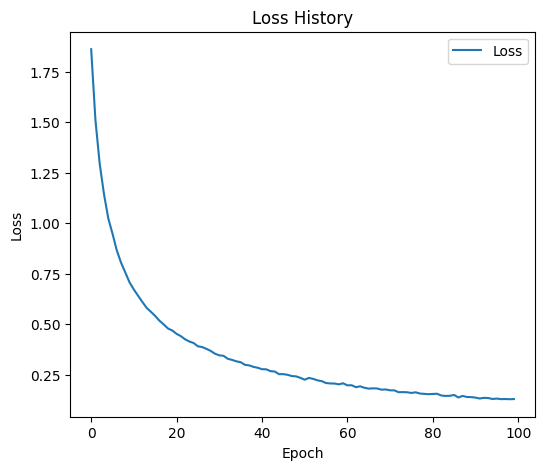

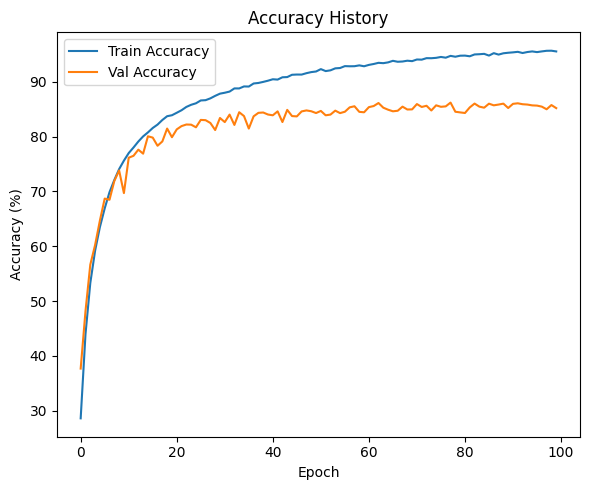

In [9]:
model.visualize_metrics()

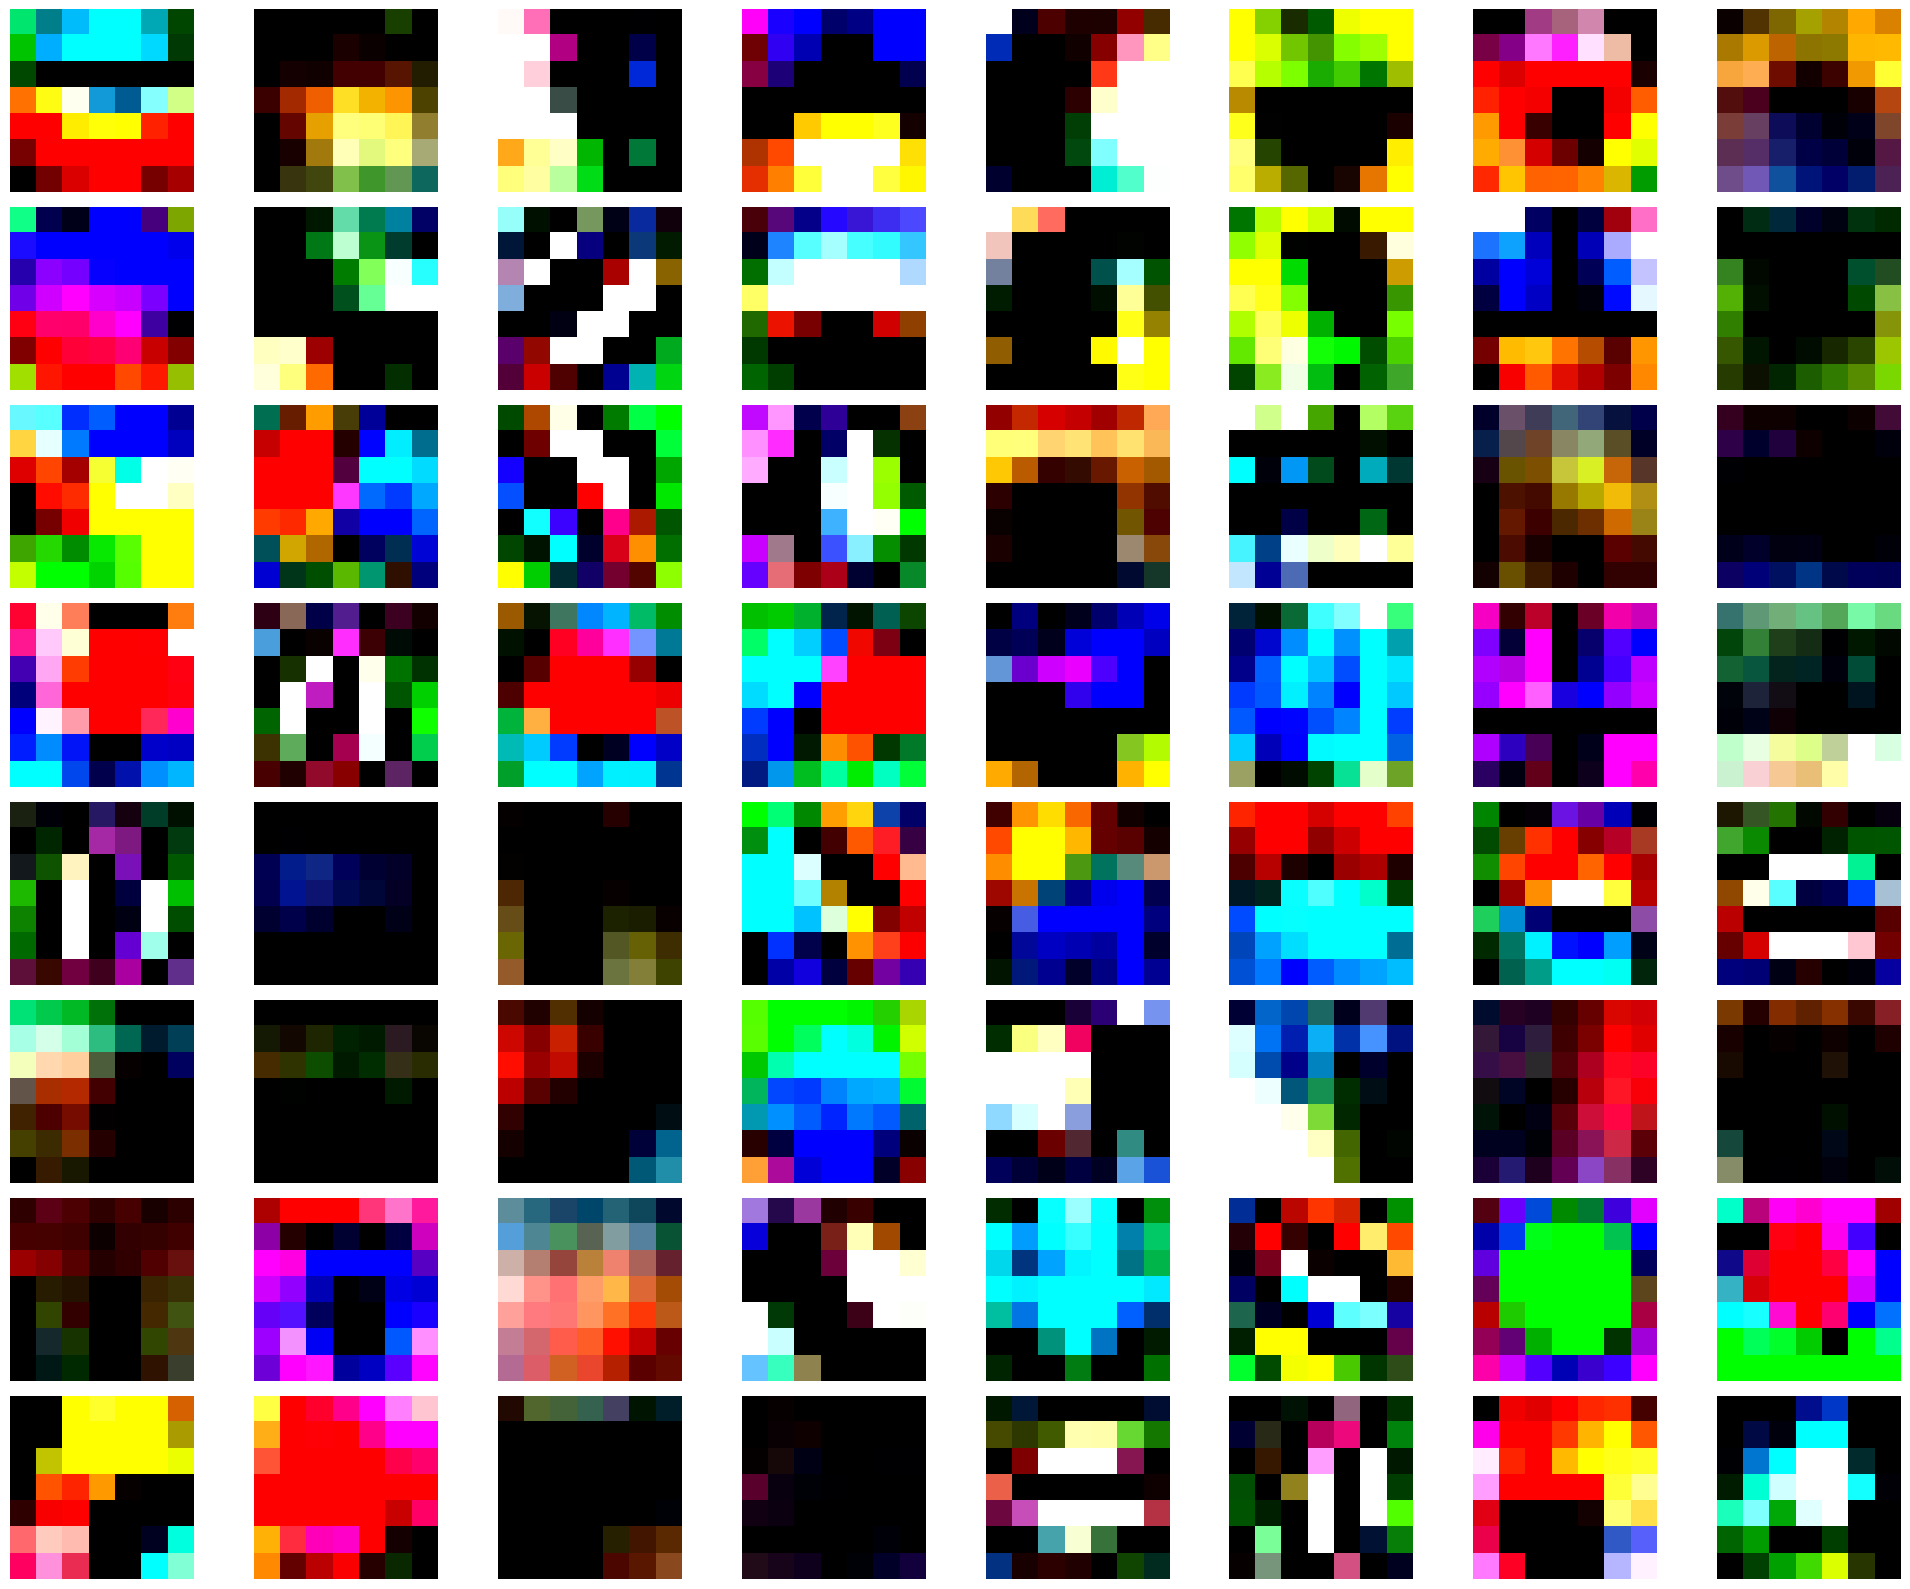

In [10]:
def visualize_conv_weights(model):
    # Access the first convolutional layer's weights
    weights = model.conv.weight.data.cpu()
    num_kernels = weights.shape[0]
    num_cols = 8  # Set number of columns for subplot
    num_rows = num_kernels // num_cols + (num_kernels % num_cols != 0)
    
    plt.figure(figsize=(20, num_rows * 2))
    
    for i in range(num_kernels):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        ax.imshow(weights[i].permute(1, 2, 0).numpy(), cmap='viridis')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_conv_weights(model)